# Aula 03 - Redes Neurais (MLP)

In [11]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary # a função summary exibe um resumo do modelo
import sklearn.datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
print('Bibliotecas importadas com sucesso!')

Bibliotecas importadas com sucesso!


## Carregando dados

In [2]:
# Vamos utilizar o dataset Iris
dados = sklearn.datasets.load_iris()
# Imprimindo algumas informações sobre o dataset:
print('Atributos:', dados['feature_names'])
print('Classes (labels):', dados['target_names'])
print('Dimensões:', dados['data'].shape)

df = pd.DataFrame(dados.data, columns=dados.feature_names)
df['label'] = [dados.target_names[i] for i in dados.target]
df

Atributos: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Classes (labels): ['setosa' 'versicolor' 'virginica']
Dimensões: (150, 4)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


c:\Program Files\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


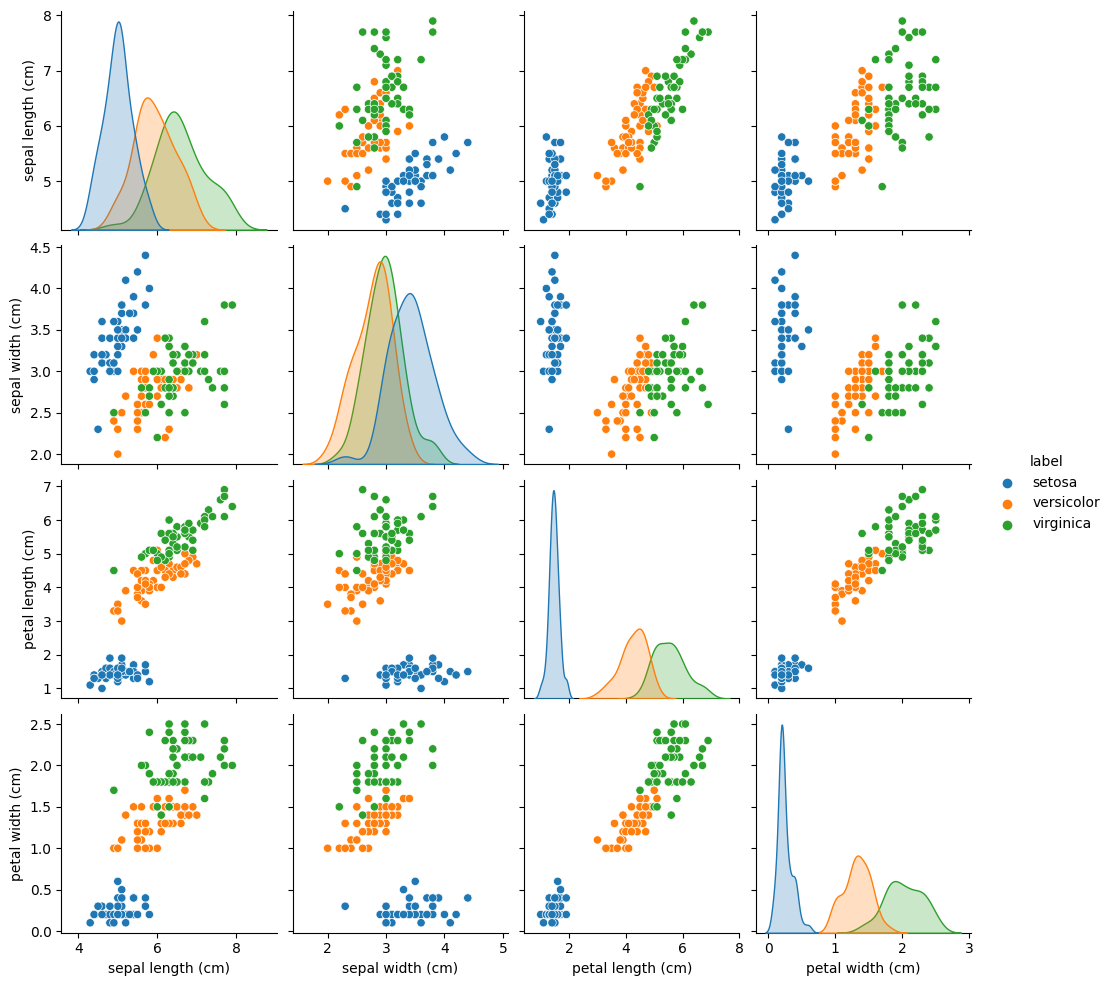

In [3]:
# Pair plot das variáveis
sns.pairplot(df, hue='label') # hue é a variável que define a cor dos pontos

## Pré-processamento dos dados

In [4]:
X = df.drop(['label'], axis=1) # removendo a coluna label
# Normalização dos dados via Min-Max
normalizador = MinMaxScaler() # instanciando o normalizador
X_norm = pd.DataFrame(normalizador.fit_transform(X), columns=X.columns) # normalizando os dados
labels = df.label.unique() # obtendo as classes
print(labels)

Y = pd.get_dummies(df.label) # criando variáveis dummy para as classes
Y

['setosa' 'versicolor' 'virginica']


,setosa,versicolor,virginica
0,True,False,False
1,True,False,False
2,True,False,False
3,True,False,False
4,True,False,False
...,...,...,...
145,False,False,True
146,False,False,True
147,False,False,True
148,False,False,True


## Seperação de conjunto Treino, Validação e Teste

In [7]:
# Separação desenvolvimento (90) e teste (10)
X_dev, X_test, Y_dev, Y_test = train_test_split(X_norm, Y, test_size=0.1, random_state=1)

# Separação treino (80) e validação (20)
X_train, X_val, Y_train, Y_val = train_test_split(X_dev, Y_dev, test_size=0.2, random_state=1)

print(X_train.shape, X_val.shape, X_test.shape)

(108, 4) (27, 4) (15, 4)


## Definindo do modelo

In [8]:
class MLP(nn.Module): # criar a classe MLP que herda de nn.Module
    def __init__(self,input_dim,output_dim): # inicializador da classe. Recebe a dimensão de entrada e de saída
        super(MLP,self).__init__() # inicializador da classe pai
        self.rede = nn.Sequential( # definindo a rede neural
            nn.Linear(input_dim, 10), # camada oculta
            nn.Tanh(), # função de ativação
            nn.Linear(10, output_dim), # camada de saída
            nn.Sigmoid(), # função de ativação
        )
    def forward(self,x): # método que define o fluxo de dados na rede
        out = self.rede(x) # passando os dados de entrada pela rede
        return out

## Instanciando o modelo

In [9]:
input_dim = 4 # dimensão de entrada
output_dim = 3 # dimensão de saída

modelo = MLP(input_dim,output_dim) # instanciando o modelo

In [12]:
print(modelo)
summary(modelo, (150,4))

MLP(
  (rede): Sequential(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=3, bias=True)
    (3): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 150, 10]              50
              Tanh-2              [-1, 150, 10]               0
            Linear-3               [-1, 150, 3]              33
           Sigmoid-4               [-1, 150, 3]               0
Total params: 83
Trainable params: 83
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


## Otimizador e Função de Custo

In [13]:
eta = 0.2 # taxa de aprendizado
loss_function = nn.MSELoss() # função de perda: erro quadrático médio

# Método do Gradiente Descendente Estocástico
optimizer = torch.optim.SGD(modelo.parameters(), lr=eta) # otimizador: Gradiente Descendente Estocástico.
# SGD: Stochastic Gradient Descent

## Treinamento

In [14]:
# Converter dados de treino para tensores
x_train = torch.FloatTensor(X_train.values)
y_train = torch.FloatTensor(Y_train.values)

x_val = torch.FloatTensor(X_val.values)
y_val = torch.FloatTensor(Y_val.values)

x_test = torch.FloatTensor(X_test.values)
y_test = torch.FloatTensor(Y_test.values)

In [15]:
# Verificar disponibilidade de GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [16]:
# Definindo o laço de treinamento da rede:
def train_network(model,optimizer,loss_function,x_train,y_train,x_val,y_val,num_epochs,train_losses,val_losses):
    for epoch in range(num_epochs):
        # zerando os gradientes da época anterior
        optimizer.zero_grad()
        
        # fase de propagação
        output_train = model(x_train)

        # cálculo do erro (função de custo - loss function)
        loss_train = loss_function(output_train, y_train)

        # fase de retroprogação
        loss_train.backward()

        # atualização dos pesos da rede
        optimizer.step()

        # avaliando o modelo com o conjunto de validação
        output_val = model(x_val)
        loss_val = loss_function(output_val,y_val)

        train_losses[epoch] = loss_train.item()
        val_losses[epoch] = loss_val.item()

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Erro Treino: {loss_train.item():.4f},  Erro Validação: {loss_val.item():.3f}")

In [17]:
num_epochs = 5000
train_losses = np.zeros(num_epochs)
val_losses = np.zeros(num_epochs)

train_network(modelo,optimizer,loss_function,x_train,y_train,x_val,y_val,num_epochs,train_losses,val_losses)

Epoch 100/5000, Erro Treino: 0.2042,  Erro Validação: 0.214
Epoch 200/5000, Erro Treino: 0.1727,  Erro Validação: 0.181
Epoch 300/5000, Erro Treino: 0.1401,  Erro Validação: 0.142
Epoch 400/5000, Erro Treino: 0.1232,  Erro Validação: 0.121
Epoch 500/5000, Erro Treino: 0.1148,  Erro Validação: 0.111
Epoch 600/5000, Erro Treino: 0.1095,  Erro Validação: 0.104
Epoch 700/5000, Erro Treino: 0.1055,  Erro Validação: 0.100
Epoch 800/5000, Erro Treino: 0.1021,  Erro Validação: 0.096
Epoch 900/5000, Erro Treino: 0.0990,  Erro Validação: 0.093
Epoch 1000/5000, Erro Treino: 0.0960,  Erro Validação: 0.089
Epoch 1100/5000, Erro Treino: 0.0931,  Erro Validação: 0.086
Epoch 1200/5000, Erro Treino: 0.0901,  Erro Validação: 0.083
Epoch 1300/5000, Erro Treino: 0.0870,  Erro Validação: 0.080
Epoch 1400/5000, Erro Treino: 0.0838,  Erro Validação: 0.076
Epoch 1500/5000, Erro Treino: 0.0804,  Erro Validação: 0.073
Epoch 1600/5000, Erro Treino: 0.0768,  Erro Validação: 0.069
Epoch 1700/5000, Erro Treino: 0.0

## Resultados

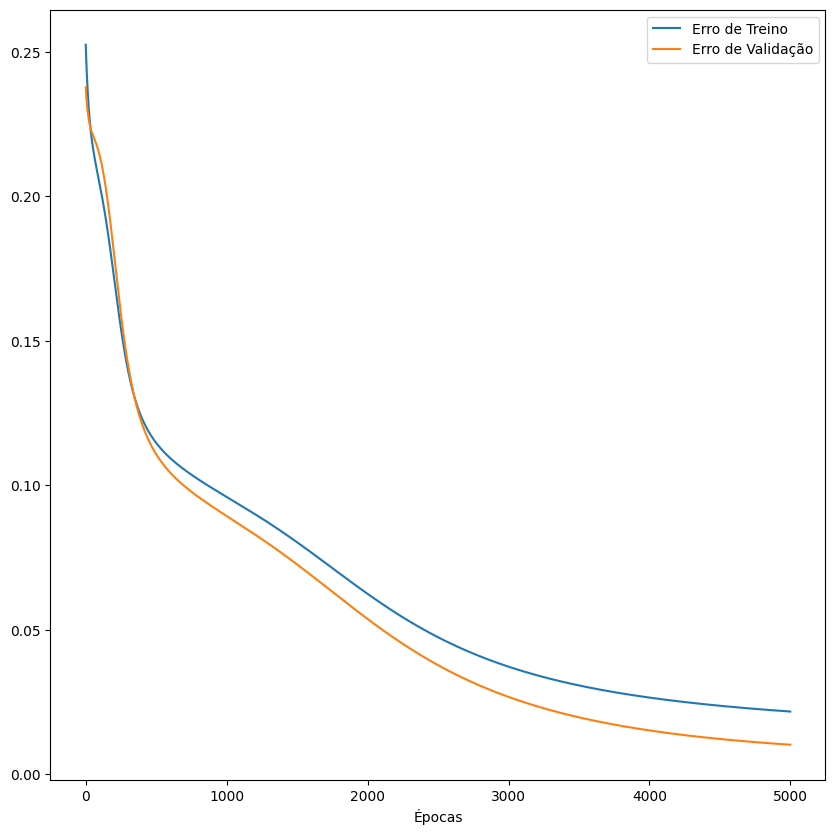

In [18]:
# Plot dos erros
plt.figure(figsize=(10,10))
plt.plot(train_losses, label='Erro de Treino')
plt.plot(val_losses, label='Erro de Validação')
plt.xlabel('Épocas')
plt.legend()
plt.show()

In [19]:
predictions_train = []
predictions_val = []
predictions_test = []

with torch.no_grad():
    predictions_train = modelo(x_train)
    predictions_val = modelo(x_val)
    predictions_test = modelo(x_test)

# Cálculo do erro:
erro_train = loss_function(predictions_train, y_train)
erro_val = loss_function(predictions_val, y_val)
erro_test = loss_function(predictions_test, y_test)

print(f'Erro de Treino: {erro_train.item():.4f}')
print(f'Erro de Validação: {erro_val.item():.4f}')
print(f'Erro de Teste: {erro_test.item():.4f}')

Erro de Treino: 0.0218
Erro de Validação: 0.0103
Erro de Teste: 0.0095
